### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289860855402632e-06


In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


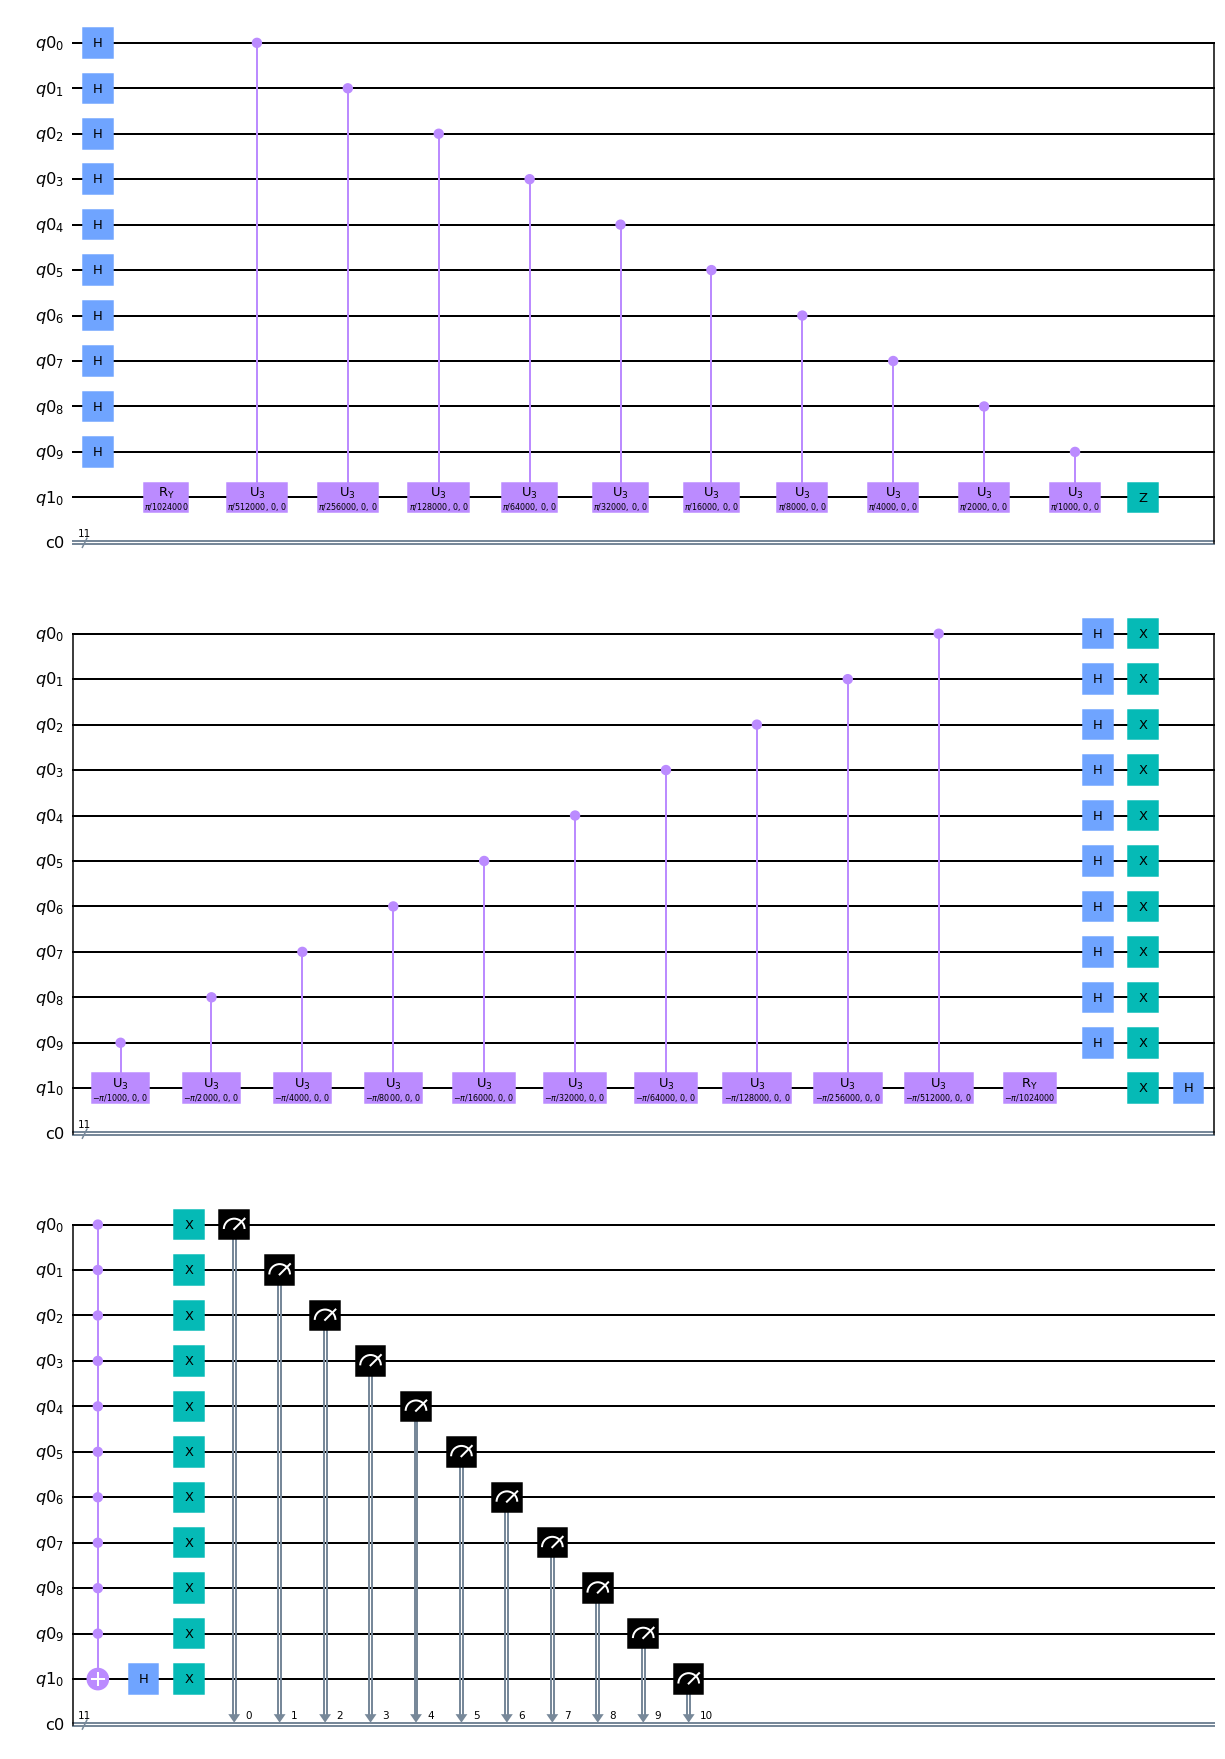

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128] # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.95, 0.05],[0.05,0.95]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
1.5222012996673584 s
1 th round with 1 oracles
0.05720186233520508 s
2 th round with 2 oracles
0.09024310111999512 s
3 th round with 3 oracles
0.09905505180358887 s
4 th round with 4 oracles
0.07561087608337402 s
5 th round with 5 oracles
0.21800494194030762 s
6 th round with 6 oracles
0.1391596794128418 s
7 th round with 7 oracles
0.1192469596862793 s
8 th round with 8 oracles
0.13251781463623047 s
9 th round with 9 oracles
0.21311211585998535 s
10 th round with 10 oracles
0.19692397117614746 s
11 th round with 11 oracles
0.28602099418640137 s
12 th round with 12 oracles
0.2616870403289795 s
13 th round with 13 oracles
0.4466681480407715 s
14 th round with 14 oracles
0.4281432628631592 s
15 th round with 15 oracles
0.35701799392700195 s
16 th round with 16 oracles
0.5867607593536377 s
17 th round with 17 oracles
0.39877867698669434 s
18 th round with 18 oracles
0.3315098285675049 s
19 th round with 19 oracles
0.46597933769226074 s
20 th round with 20 oracles


In [15]:
import pickle
with open("raw_result_p005_q005_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_p005_q005_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[56, 48, 57, 58, 64, 61, 57, 61, 51, 54, 60, 57, 59, 61, 62, 55, 56, 61, 60, 54, 54, 65, 63, 56, 51, 62, 56, 58, 54, 65, 64, 56, 57, 54, 51, 55, 53, 54, 51, 54, 60, 50, 55, 55, 67, 55, 54, 56, 57, 56, 56, 61, 63, 53, 49, 55, 56, 59, 53, 57, 57, 59, 61, 59, 59, 54, 45, 53, 50, 62, 45, 45, 58, 56, 54, 51, 57, 49, 64, 51, 58, 49, 50, 53, 64, 46, 48, 49, 58, 49, 47, 52, 51, 48, 54, 49, 48, 58, 48, 42]


## Mitigation

In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)
print(mit_hit_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0
number of positive values:  1014
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  1026
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999993
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999968
number of positive values:  1020
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999977
number of positive values:  1040
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000029
number of positive values:  1026
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999998
number of positive values:  1027
main process: Done!
strict inverse + SGS a

sum of mitigated probability vector x: 0.9999999999999986
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999966
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999981
number of positive values:  1030
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999998
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999971
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999969
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999953
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of 

In [21]:
meas_filter = InvSSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_list.append(x_tilde)
mit_hit_S_list = make_hit_list(x_tilde_S_list)
print(mit_hit_S_list)

Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1721736560129166
number of positive values:  14
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.2445609313357455
number of positive values:  19
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.275542035447653
number of positive values:  16
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.15215979691976
number of positive values:  13
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.113330421535462
number of positive values:  7
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1239598915192541
number of positive values:  14
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_

sum of mitigated probability vector x_s: 1.1718159027266206
number of positive values:  19
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.18197499445918
number of positive values:  13
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1486547359464532
number of positive values:  13
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1897596522682692
number of positive values:  18
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.2417951893810932
number of positive values:  17
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.2242630956360043
number of positive values:  18
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1977552163690346
number of positive

In [12]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.171552752062683
sum of mitigated probability vector x_hat_s: 1.1712887814480628
0.027721166610717773 s
number of positive values:  15
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2437507143461657
sum of mitigated probability vector x_hat_s: 1.2434787469394468
0.023350000381469727 s
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2691279582728876
sum of mitigated probability vector x_hat_s: 1.2688624717739934
0.021189212799072266 s
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1524102156115674
sum of mitigated probability vector x_hat_s: 1.1521579050219581
0.018715858459472656 s


sum of mitigated probability vector x_s: 1.1530789460756354
sum of mitigated probability vector x_hat_s: 1.1527715401212524
0.03770279884338379 s
number of positive values:  15
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2458251895175192
sum of mitigated probability vector x_hat_s: 1.2455771567777727
0.028183937072753906 s
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2066771869441493
sum of mitigated probability vector x_hat_s: 1.206376203483108
0.04379892349243164 s
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.167387121508801
sum of mitigated probability vector x_hat_s: 1.167098790589032
0.035225868225097656 s
number of positive values:  18
main process: Done!
Restriction to lab

sum of mitigated probability vector x_s: 1.1931451606517802
sum of mitigated probability vector x_hat_s: 1.1929044418548356
0.043845176696777344 s
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1807683357759742
sum of mitigated probability vector x_hat_s: 1.1804521614663719
0.06206512451171875 s
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.250094974067516
sum of mitigated probability vector x_hat_s: 1.2497656773186927
0.050553083419799805 s
number of positive values:  23
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.25361402040731
sum of mitigated probability vector x_hat_s: 1.2533531364746333
0.02991795539855957 s
number of positive values:  19
main process: Done!
Restriction to lab

0.05456209182739258 s
number of positive values:  24
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.208292947359062
sum of mitigated probability vector x_hat_s: 1.2079559506962618
0.05972766876220703 s
number of positive values:  23
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2810367375543936
sum of mitigated probability vector x_hat_s: 1.2807611475434828
0.03350400924682617 s
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.225267095538762
sum of mitigated probability vector x_hat_s: 1.2249368699570917
0.051654815673828125 s
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2959644697459431
sum of mitigated 

In [13]:
import mooney_etal
importlib.reload(mooney_etal)
from mooney_etal import MooneyEtal
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, 1 / 100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney100_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney100_list)

The heuristcs by Mooney et al. + SGS algorithm
{32: -0.01926904446411247, 1280: 0.017214731867202036, 136: 0.0162560433140052, 256: -0.015978349672673055, 4: 0.019292593523211814, 8: -0.019102907162811118, 1: 0.018025862829372012, 96: 0.016187130934893827, 1024: -0.022123859741673337, 16: 0.040906331674831445, 512: 0.03714932224723053, 0: 0.9912860547080317}
sum of counts: 1.0798439100575086
0.0030939579010009766 s
number of positive values:  8
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{32: 0.06221049273865294, 1024: 0.024550381928594156, 1034: 0.017054781947425216, 256: 0.011743091739550631, 8: -0.030660370457019463, 128: 0.022724777949455547, 1: 0.025866456651096832, 64: 0.06506768194023066, 10: 0.016218674611959066, 16: 0.06538271042236292, 0: 0.8397720418584705, 136: 0.034080561063378374}
sum of counts: 1.1540112823941573
0.0035109519958496094 s
number of positive values:  11
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{272: 0.0147141

{32: -0.04001437103489807, 1536: 0.01458138435864282, 264: 0.014626242865961607, 1280: 0.01570269634162931, 16: -0.017725543466266543, 1: -0.022349443872213246, 140: 0.018131774174709535, 128: 0.06854338136035067, 8: 0.05041364970449157, 0: 1.0672871118537828, 44: 0.018110914460342898, 512: -0.021512745458749486, 1024: 0.026940207365335984, 256: -0.037832645192235795, 4: -0.039514963438918346}
sum of counts: 1.1153876500219657
0.0057642459869384766 s
number of positive values:  9
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{132: 0.016280180389110808, 1552: 0.01815020016385155, 20: 0.016426504562278992, 1120: 0.01625902769866812, 260: 0.03262749633151566, 320: 0.013291975890931378, 1796: 0.017186289114345315, 1540: 0.01628808503234383, 1024: 0.05735512210849831, 96: 0.030295366564751916, 8: 0.0245669841800878, 128: -0.013491211667810575, 256: 0.024934461451678762, 516: 0.015451073555800214, 32: 0.0218611823346364, 64: 0.02387321041731897, 512: -0.01202074806528525

{1120: 0.018038769638060715, 512: -0.014298878368852139, 1024: 0.01838736781993445, 1: 0.04115373886331146, 544: 0.017025960609270464, 1536: 0.033191435732343025, 36: 0.01496913748582473, 4: 0.023263185408837234, 256: 0.06257167792430791, 32: -0.015491565856580763, 8: 0.040331535860826405, 128: 0.021521836641458267, 40: 0.014046040423913931, 16: -0.02760359386939979, 0: 0.898405432238187}
sum of counts: 1.145512080551443
0.006348848342895508 s
number of positive values:  12
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{640: 0.016591516639476223, 768: 0.017477731780940683, 1538: 0.018096492993725153, 1: -0.021280832788104456, 1024: 0.0831882309767948, 1058: 0.017007832996984204, 65: 0.01923086856254222, 128: 0.012845623183199761, 8: -0.019697950548238426, 528: 0.0356443972238076, 2: -0.04183994431977612, 512: -0.04114465634125116, 160: 0.014296737731895355, 0: 1.0347411379287101, 4: -0.01941922731731022}
sum of counts: 1.1257379587033958
0.009352922439575195 s
numb

number of positive values:  11
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{192: 0.015840520207429362, 320: 0.014204273762518756, 0: 0.8646636171277162, 1296: 0.018145577968893243, 4: 0.025862952134613884, 1026: 0.027974034060295732, 384: 0.015361560682459478, 64: 0.04115816909091156, 1100: 0.018006410139044162, 1: -0.029796132262703053, 1408: 0.017166188043847435, 96: 0.013368498031395669, 1024: 0.091812998985307}
sum of counts: 1.1337686679717296
0.00461268424987793 s
number of positive values:  12
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{132: 0.01724444639260616, 832: 0.018213550000816266, 1121: 0.01797403167986208, 32: -0.02812640346721549, 256: -0.025218682753802412, 64: 0.04568881837387657, 128: -0.029618454651450188, 522: 0.018147962537845605, 528: 0.013176205945692257, 578: 0.018173631508903384, 1024: 0.12927273684461418, 512: 0.024547297229175064, 16: 0.028076407950808947, 0: 0.843473448208742}
sum of counts: 1.0910249958004745

In [14]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, 1 / 10)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney10_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney10_list)

The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0207590315417276}
sum of counts: 1.0207590315417276
0.0013897418975830078 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8744137851371893}
sum of counts: 0.8744137851371893
0.0006570816040039062 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.042709880632334}
sum of counts: 1.042709880632334
0.0005919933319091797 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0600886131103913}
sum of counts: 1.0600886131103913
0.0005309581756591797 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.1680187012687753}
sum of counts: 1.1680187012687753
0.0010428428649902344 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al

0.0016818046569824219 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.2238125919929868}
sum of counts: 1.2238125919929868
0.0006127357482910156 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0024658757411604}
sum of counts: 1.0024658757411604
0.0006129741668701172 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.9814294499730636}
sum of counts: 0.9814294499730636
0.0029327869415283203 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.022587878186747}
sum of counts: 1.022587878186747
0.008585929870605469 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0372233406972748}
sum of counts: 1.0372233406972748
0.002803802490234375 s
number 

sum of counts: 0.9677084107850452
0.005574941635131836 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.1698475479137949}
sum of counts: 1.1698475479137949
0.0006380081176757812 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8369130502135449}
sum of counts: 0.8369130502135449
0.002332925796508789 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8744137851371893}
sum of counts: 0.8744137851371893
0.0006191730499267578 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8963646342277958}
sum of counts: 0.8963646342277958
0.0090398788452148

In [23]:
import pickle
with open("hit_list_p005_q005_piover1000.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [24]:
import pickle
with open("mit_hit_list_p005_q005_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [25]:
import pickle
with open("mit_hit_S_list_p005_q005_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)

In [26]:
import pickle
with open("mit_hit_S_lm_0_list_p005_q005_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

Text(0, 0.5, 'number of shots for $|00...0>$')

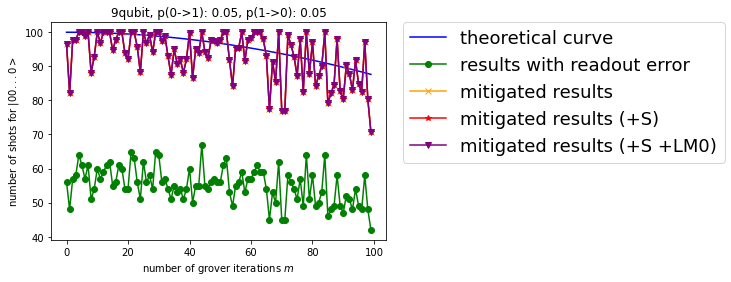

In [27]:
divide = 100
# plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, 100 * np.cos(2 * np.array(number_grover_list) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_list, marker="*", label="mitigated results (+S)", color="red")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("9qubit, p(0->1): 0.05, p(1->0): 0.05")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

## Post-processing

In [15]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney100_list = [100 - h for h in mit_hit_mooney100_list]
sin_mit_hit_mooney10_list = [100 - h for h in mit_hit_mooney10_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney100_list = calculate_theta(
    sin_mit_hit_mooney100_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney10_list = calculate_theta(
    sin_mit_hit_mooney10_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney100_list = np.abs(np.sin(thetaCandidate_mit_mooney100_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney10_list = np.abs(np.sin(thetaCandidate_mit_mooney10_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

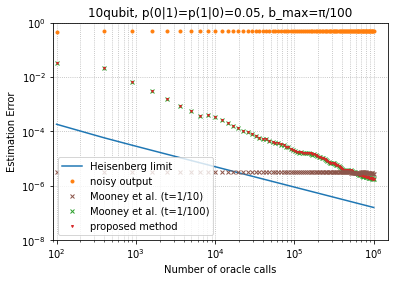

In [16]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)

plt.title("10qubit, p(0|1)=p(1|0)=0.05, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method"))
plt.show()